<a href="https://colab.research.google.com/github/angel870326/XLNet_Text_Classification/blob/main/brand/xlnet_multi_class_chinese_train_brand_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 2022.05.17 Ssu-Yun Wang<br/>
[Github @angel870326](https://github.com/angel870326)

# **XLNet Multi-class Text Classification for Chinese and English**
Available for both multi-label and single-label classification.

## **Contents**
1. Dataset
   *   Raw dataset
   *   Clean dataset
   *   Convert 'brand' to dummy variables
   *   Get small sample of train and test to try (optional)
<br/>
2. Preprocessing<br/>
   (1) XLNetTokenizer & Sentence embedding<br/>
   (2) Tokenize input texts into ids<br/>
   (3) Create attention masks<br/>
   (4) Add input ids and attention masks to the dataframe<br/>
3. Train, Valid Split<br/>
4. Create Dataloaders (torch tensors)<br/>
5. Training<br/>
   (1) Functions<br/>
   (2) Train model from scratch<br/>
   (3) Train model from previous checkpoint<br/>
6. Get Predictions<br/>
   (1) Testing<br/>
   (2) For single-label classification<br/>
   (3) Save the predicting results<br/>
7. Evaluation<br/>
   (1) Accuracy<br/>
   (2) Precision, Recall & F1<br/>


** Modified from  https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df*

In [ ]:
!pip install transformers
# !pip install sentencepiece # for English

     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 12.5 MB/s 
     |████████████████████████████████| 596 kB 3.9 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import math
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# GPU
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80


## **1. Dataset**


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Raw dataset

In [ ]:
train_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/資料檔/brand_train.csv')
test_raw = pd.read_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/資料檔/brand_test.csv')

In [ ]:
train_raw.head()

,id,name,brand,clean_name,clean_brand
0,14522,(e)歐斯恩-全齡犬糧紐西蘭草飼鹿1.6kg,歐斯恩,e歐斯恩-全齡犬糧紐西蘭草飼鹿,歐斯恩
1,59813,【contin康定】網紅愛用酵素植萃洗髮乳(4入組),康定 contin,contin康定網紅愛用酵素植萃洗髮乳組,康定contin
2,33677,台鹽膠原美妍洗面乳100ml,台鹽生技,台鹽膠原美妍洗面乳,台鹽生技
3,36232,麗仕沐浴乳水嫩柔膚,麗仕,麗仕沐浴乳水嫩柔膚,麗仕
4,35438,暖象牙米高保濕修護精華粉底-升級版,bobbi brown 芭比波朗,暖象牙米高保濕修護精華粉底-升級版,芭比波朗bobbi brown


In [ ]:
test_raw.head()

,id,name,brand,clean_name,clean_brand
0,60992,福樂麥芽牛乳,福樂,福樂麥芽牛乳,福樂
1,66147,kose光映透美肌職人-日本酒保濕面膜(7入),kose 高絲,kose光映透美肌職人-日本酒保濕面膜,高絲kose
2,56070,勁威3合1衛生套,勁威,勁威3合1衛生套,勁威
3,29278,sakura櫻花兩口檯面式安全瓦斯爐g615as(天然瓦斯ng1),櫻花 sakura,sakura櫻花兩口檯面式安全瓦斯爐g615as天然瓦斯ng1,櫻花sakura
4,48047,ns《電力加強版主機》藍紅版+任你選1款遊戲軟體(台灣公司貨)(任天堂nintendoswi...,switch,ns電力加強版主機藍紅版任你選遊戲軟體台灣公司貨任天堂nintendoswitch,switch


### Clean dataset

In [ ]:
train_data = {'id': train_raw['id'],
              'name': train_raw['clean_name'],
              'brand': train_raw['clean_brand']}
train_clean = pd.DataFrame(train_data)
train_clean

,id,name,brand
0,14522,e歐斯恩-全齡犬糧紐西蘭草飼鹿,歐斯恩
1,59813,contin康定網紅愛用酵素植萃洗髮乳組,康定contin
2,33677,台鹽膠原美妍洗面乳,台鹽生技
3,36232,麗仕沐浴乳水嫩柔膚,麗仕
4,35438,暖象牙米高保濕修護精華粉底-升級版,芭比波朗bobbi brown
...,...,...,...
56026,37195,nikejordanmarsow-db,耐吉nike
56027,6266,catrice粉漾潤色唇膏,卡翠絲catrice
56028,54887,philips飛利浦4kandroid聯網液晶顯示器視訊盒55puh7374-網,飛利浦philips
56029,861,沛特斯白麝香洗髮精,沛特斯petal fresh


In [ ]:
test_data = {'id': test_raw['id'],
             'name': test_raw['clean_name'],
             'brand': test_raw['clean_brand']}
test = pd.DataFrame(test_data)
test

,id,name,brand
0,60992,福樂麥芽牛乳,福樂
1,66147,kose光映透美肌職人-日本酒保濕面膜,高絲kose
2,56070,勁威3合1衛生套,勁威
3,29278,sakura櫻花兩口檯面式安全瓦斯爐g615as天然瓦斯ng1,櫻花sakura
4,48047,ns電力加強版主機藍紅版任你選遊戲軟體台灣公司貨任天堂nintendoswitch,switch
...,...,...,...
14003,50092,韓國cjlion抗敏牙膏淨白牙膏夜間防護牙膏兒童牙膏,cj lion
14004,27456,kinyohz直立式無線滑鼠gkm,耐嘉kinyo
14005,28520,葡萄王夜極薑黃複方膠囊狂降399元,葡萄王
14006,69975,萊萃美超級b群c二入超,萊萃美


### Convert 'brand' to dummy variables

In [ ]:
train = train_clean[['id', 'name']]
brands = pd.get_dummies(train_clean['brand'])
train = pd.concat([train, brands], axis=1)
train

,id,name,080,1028,16 brand,17pin,1st choice,21plus,24h cosme,3ce,...,齊葉雅ziaja,齋藤咖啡店,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬
0,14522,e歐斯恩-全齡犬糧紐西蘭草飼鹿,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,59813,contin康定網紅愛用酵素植萃洗髮乳組,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33677,台鹽膠原美妍洗面乳,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,36232,麗仕沐浴乳水嫩柔膚,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,35438,暖象牙米高保濕修護精華粉底-升級版,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56026,37195,nikejordanmarsow-db,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56027,6266,catrice粉漾潤色唇膏,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56028,54887,philips飛利浦4kandroid聯網液晶顯示器視訊盒55puh7374-網,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56029,861,沛特斯白麝香洗髮精,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get small sample of train and test to try (optional)

In [ ]:
# train = train.sample(n=1000)
# test = test.sample(n=100)

## **2. Preprocessing**


---



### (1) XLNetTokenizer & Sentence embedding

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
# XLNetTokenizer (for English)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# AutoTokenizer (for Chinese)
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-xlnet-base")

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/675k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [ ]:
# Texts for classification
train_text_list = train['name'].values
test_text_list = test['name'].values

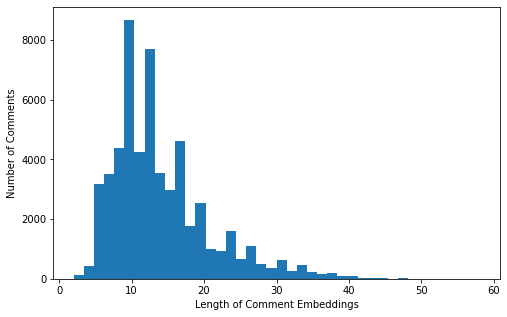

In [ ]:
# train
plot_sentence_embeddings_length(train_text_list, tokenizer)

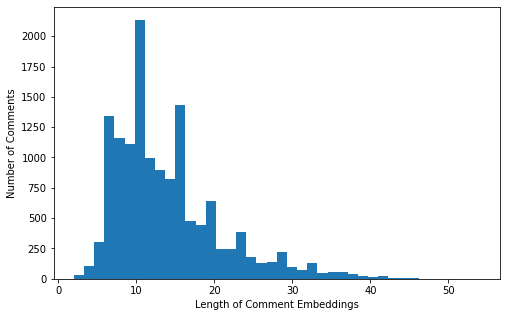

In [ ]:
# test
plot_sentence_embeddings_length(test_text_list, tokenizer)

### (2) Tokenize input texts into ids
*   Append the appropriate special characters to the end of the text to denote end of sentence.
*   Truncate or pad the appropriate sequence length.



In [ ]:
# 這裡可能要再改
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    # tokenize the text, then truncate sequence to the desired length minus 2 for the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

In [ ]:
# Create input id tokens (train)
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
train_input_ids

array([[   19,   628,  1246, ...,     0,     0,     0],
       [10045, 11941,   548, ...,     0,     0,     0],
       [   19,   200,  3077, ...,     0,     0,     0],
       ...,
       [   19,  5357, 17304, ...,     0,     0,     0],
       [   19,  8515, 10634, ...,     0,     0,     0],
       [   19,    95,   512, ...,     0,     0,     0]])

In [ ]:
# Create input id tokens (test)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=50) # number of embeddings can be modified
test_input_ids

array([[   19,   512,   774, ...,     0,     0,     0],
       [   19,  9057,  2912, ...,     0,     0,     0],
       [   19,  8883,   694, ...,     0,     0,     0],
       ...,
       [   19,  8107,   103, ...,     0,     0,     0],
       [   19,  1399, 14762, ...,     0,     0,     0],
       [   19,   182,  1537, ...,     0,     0,     0]])

### (3) Create attention masks
*   Tell model whether attention should be applied to the input id tokens.
*   Do not want to perform attention on padding tokens.

In [ ]:
def create_attn_masks(input_ids):
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# Create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)

### (4) Add input ids and attention masks to the dataframe

In [ ]:
# train
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks
# test
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [ ]:
train.head()

,id,name,080,1028,16 brand,17pin,1st choice,21plus,24h cosme,3ce,...,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬,features,masks
0,14522,e歐斯恩-全齡犬糧紐西蘭草飼鹿,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 628, 1246, 102, 370, 13, 213, 6224, 3576,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,59813,contin康定網紅愛用酵素植萃洗髮乳組,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[10045, 11941, 548, 282, 1630, 729, 601, 136, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,33677,台鹽膠原美妍洗面乳,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 200, 3077, 6171, 210, 214, 16983, 3002, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,36232,麗仕沐浴乳水嫩柔膚,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 1627, 5164, 16459, 8963, 3250, 111, 12140...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,35438,暖象牙米高保濕修護精華粉底-升級版,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"[19, 5883, 21077, 10487, 666, 9505, 579, 2267,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test.head()

,id,name,brand,features,masks
0,60992,福樂麥芽牛乳,福樂,"[19, 512, 774, 1729, 8223, 1104, 3250, 4, 3, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,66147,kose光映透美肌職人-日本酒保濕面膜,高絲kose,"[19, 9057, 2912, 182, 5578, 5739, 214, 6374, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,56070,勁威3合1衛生套,勁威,"[19, 8883, 694, 51, 362, 41, 6233, 1598, 4, 3,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,29278,sakura櫻花兩口檯面式安全瓦斯爐g615as天然瓦斯ng1,櫻花sakura,"[19, 150, 6254, 15039, 21680, 306, 255, 23329,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,48047,ns電力加強版主機藍紅版任你選遊戲軟體台灣公司貨任天堂nintendoswitch,switch,"[19, 629, 150, 6268, 5768, 413, 13660, 1684, 7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## **3. Train, Valid Split**


---



In [ ]:
# train valid split
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

# brands column names
label_cols = brands.columns.values.tolist()
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

## **4. Create Dataloaders (torch tensors)**
---

Convert all of the input ids and attention masks into torch tensors, the required datatype for the model.


In [ ]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. 
# With an iterator, the entire dataset does not need to be loaded into memory.
train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

## **5. Training**


---



### (1) Functions

Train the model and save the model with the lowest validation loss.

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
    """
    Training
    """
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      # scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    print("Train loss: {}".format(epoch_train_loss))

    """
    Validation
    """
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()
    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    # Update tracking variables
    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set

Save the model to the path directory provided.

In [ ]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return

Load the model from the path directory provided.

In [ ]:
def load_model(save_path):
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

### (2) Train model from scratch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    # self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased') # for English
    self.xlnet = AutoModel.from_pretrained("hfl/chinese-xlnet-base")
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Need GPU
# Modify output path

num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/xlnet_brand_train.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.0003434575907918233
Valid loss: 0.00013836787218625044


Epoch:  33%|███▎      | 1/3 [19:04<38:08, 1144.10s/it]

Saving model at epoch 0 with validation loss of 0.00013836787218625044


Train loss: 0.00013719327641410767
Valid loss: 0.00013451510984236175


Epoch:  67%|██████▋   | 2/3 [38:21<19:11, 1151.89s/it]

Saving model at epoch 1 with validation loss of 0.00013451510984236175


Train loss: 0.00011227315085168268
Valid loss: 7.325725587045166e-05


Epoch: 100%|██████████| 3/3 [57:42<00:00, 1154.00s/it]

Saving model at epoch 2 with validation loss of 7.325725587045166e-05




Text(0.5, 1.0, 'Loss vs Number of Epochs')

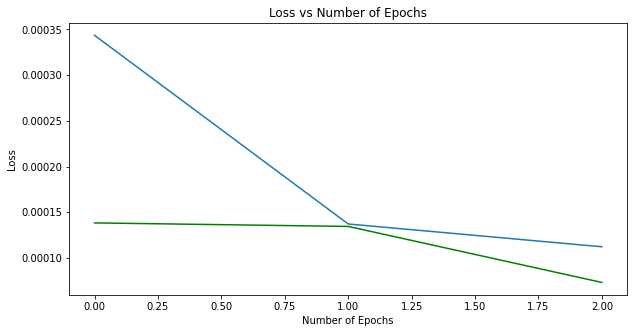

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

### (3) Train model from previous checkpoint

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/xlnet_brand_train.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

Some weights of the model checkpoint at hfl/chinese-xlnet-base were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
num_epochs=3
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 5.578613456677325e-05
Valid loss: 3.955394111218145e-05


Epoch:  33%|███▎      | 1/3 [19:20<38:41, 1160.70s/it]

Saving model at epoch 2 with validation loss of 3.955394111218145e-05


Train loss: 3.406196823068127e-05
Valid loss: 2.9262948680885634e-05


Epoch:  67%|██████▋   | 2/3 [38:41<19:20, 1160.54s/it]

Saving model at epoch 3 with validation loss of 2.9262948680885634e-05


Train loss: 2.43420883806726e-05
Valid loss: 2.3649847523397047e-05


Epoch: 100%|██████████| 3/3 [58:01<00:00, 1160.62s/it]

Saving model at epoch 4 with validation loss of 2.3649847523397047e-05




Text(0.5, 1.0, 'Loss vs Number of Epochs')

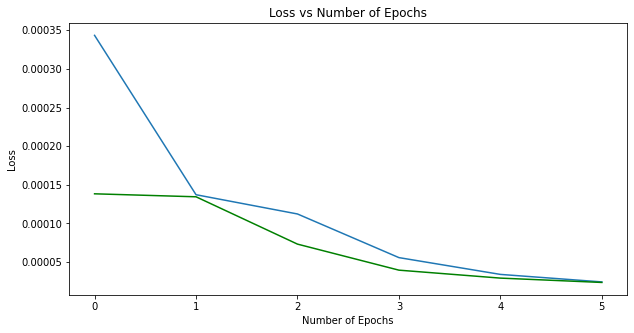

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
# ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## **6. Get Predictions**


---



### (1) Testing

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[6.17226615e-05, 8.49320277e-05, 1.05397094e-05, ...,
        4.50897687e-06, 1.48731488e-05, 2.58903110e-05],
       [2.94615631e-04, 1.28597376e-05, 3.84674750e-05, ...,
        6.33872060e-06, 2.77255695e-05, 2.96016174e-06],
       [1.59086703e-04, 7.43068813e-05, 9.52808914e-05, ...,
        2.06786444e-05, 1.11596040e-04, 7.46503076e-07],
       ...,
       [5.67238094e-05, 2.56600888e-05, 6.62680441e-06, ...,
        1.31293109e-05, 3.72748327e-05, 6.11783980e-06],
       [2.09272021e-05, 1.57731938e-06, 3.67430039e-05, ...,
        2.77760355e-05, 6.69569941e-04, 7.64893921e-05],
       [8.30151024e-04, 1.35777416e-04, 5.69446729e-06, ...,
        8.13185807e-07, 5.30823445e-06, 2.33556093e-05]])

In [ ]:
for i in label_cols:
  test[i] = pred_probs[:,label_cols.index(i)]

test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,brand,features,masks,080,1028,16 brand,17pin,1st choice,...,齊葉雅ziaja,齋藤咖啡店,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬
0,60992,福樂麥芽牛乳,福樂,"[19, 512, 774, 1729, 8223, 1104, 3250, 4, 3, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000062,0.000085,0.000011,0.000005,0.000007,...,0.000006,0.000025,0.000084,0.000002,0.000008,0.000069,0.000034,0.000005,0.000015,2.589031e-05
1,66147,kose光映透美肌職人-日本酒保濕面膜,高絲kose,"[19, 9057, 2912, 182, 5578, 5739, 214, 6374, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000295,0.000013,0.000038,0.000004,0.000007,...,0.000014,0.000006,0.000016,0.000012,0.000090,0.000021,0.000009,0.000006,0.000028,2.960162e-06
2,56070,勁威3合1衛生套,勁威,"[19, 8883, 694, 51, 362, 41, 6233, 1598, 4, 3,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000159,0.000074,0.000095,0.000011,0.000002,...,0.000035,0.000018,0.000012,0.000047,0.001375,0.000032,0.000100,0.000021,0.000112,7.465031e-07
3,29278,sakura櫻花兩口檯面式安全瓦斯爐g615as天然瓦斯ng1,櫻花sakura,"[19, 150, 6254, 15039, 21680, 306, 255, 23329,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000070,0.000040,0.000122,0.000011,0.000027,...,0.000137,0.000066,0.000088,0.000011,0.000128,0.000249,0.000028,0.000039,0.000293,2.881026e-05
4,48047,ns電力加強版主機藍紅版任你選遊戲軟體台灣公司貨任天堂nintendoswitch,switch,"[19, 629, 150, 6268, 5768, 413, 13660, 1684, 7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000020,0.000039,0.000002,0.000006,0.000044,...,0.000004,0.000024,0.000010,0.000012,0.000011,0.000003,0.000006,0.000020,0.000007,6.530034e-05


### (2) For single-label classification

In [ ]:
# Get the maximum probability for each row
test['brand_predict'] = test.iloc[:,5:].idxmax(axis = 1)
test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,id,name,brand,features,masks,080,1028,16 brand,17pin,1st choice,...,齋藤咖啡店,齒妍堂,齒方籤,齒磨撫子,龍宏,龍泉,龍馬,龍鳳,龜甲萬,brand_predict
0,60992,福樂麥芽牛乳,福樂,"[19, 512, 774, 1729, 8223, 1104, 3250, 4, 3, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000062,0.000085,0.000011,0.000005,7.026035e-06,...,0.000025,0.000084,2.242921e-06,0.000008,0.000069,0.000034,4.508977e-06,0.000015,2.589031e-05,福樂
1,66147,kose光映透美肌職人-日本酒保濕面膜,高絲kose,"[19, 9057, 2912, 182, 5578, 5739, 214, 6374, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000295,0.000013,0.000038,0.000004,6.595708e-06,...,0.000006,0.000016,1.178065e-05,0.000090,0.000021,0.000009,6.338721e-06,0.000028,2.960162e-06,高絲kose
2,56070,勁威3合1衛生套,勁威,"[19, 8883, 694, 51, 362, 41, 6233, 1598, 4, 3,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000159,0.000074,0.000095,0.000011,2.391215e-06,...,0.000018,0.000012,4.668935e-05,0.001375,0.000032,0.000100,2.067864e-05,0.000112,7.465031e-07,勁威
3,29278,sakura櫻花兩口檯面式安全瓦斯爐g615as天然瓦斯ng1,櫻花sakura,"[19, 150, 6254, 15039, 21680, 306, 255, 23329,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000070,0.000040,0.000122,0.000011,2.680103e-05,...,0.000066,0.000088,1.142427e-05,0.000128,0.000249,0.000028,3.894630e-05,0.000293,2.881026e-05,櫻花sakura
4,48047,ns電力加強版主機藍紅版任你選遊戲軟體台灣公司貨任天堂nintendoswitch,switch,"[19, 629, 150, 6268, 5768, 413, 13660, 1684, 7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000020,0.000039,0.000002,0.000006,4.384319e-05,...,0.000024,0.000010,1.242679e-05,0.000011,0.000003,0.000006,2.021671e-05,0.000007,6.530034e-05,switch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14003,50092,韓國cjlion抗敏牙膏淨白牙膏夜間防護牙膏兒童牙膏,cj lion,"[19, 1448, 1214, 3593, 2518, 1402, 1952, 1841,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000059,0.000041,0.000107,0.000025,2.142937e-05,...,0.000022,0.000015,5.764565e-06,0.000624,0.000237,0.000001,2.992809e-05,0.000024,9.167959e-06,獅王lion
14004,27456,kinyohz直立式無線滑鼠gkm,耐嘉kinyo,"[19, 16037, 14600, 1141, 1875, 18851, 208, 138...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000006,0.000004,0.000014,0.000004,3.863910e-06,...,0.000070,0.000053,3.147654e-05,0.000028,0.000162,0.000004,5.928318e-05,0.000022,7.208868e-05,耐嘉kinyo
14005,28520,葡萄王夜極薑黃複方膠囊狂降399元,葡萄王,"[19, 8107, 103, 1148, 1235, 22378, 609, 6976, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000057,0.000026,0.000007,0.000021,1.202943e-04,...,0.000016,0.000127,1.676270e-06,0.000018,0.000021,0.000017,1.312931e-05,0.000037,6.117840e-06,葡萄王
14006,69975,萊萃美超級b群c二入超,萊萃美,"[19, 1399, 14762, 214, 3365, 1123, 613, 1214, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000021,0.000002,0.000037,0.000094,3.848802e-06,...,0.000009,0.000004,6.130461e-06,0.000159,0.000036,0.000010,2.777604e-05,0.000670,7.648939e-05,萊萃美


### (3) Save the predicting results

In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/brand_train_1_epoch.csv")
test.to_csv(pred_save_path, index=False)

## **7. Evaluation**


---



In [ ]:
y_test = test['brand']
y_predict = test['brand_predict']

### (1) Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict)

0.8609366076527698

### (2) Precision, Recall & F1

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_predict, labels=np.unique(y_predict))
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                           precision    recall  f1-score   support

                     1028       0.99      0.97      0.98        72
                      3ce       0.00      0.00      0.00         0
                       3m       0.41      0.58      0.48        12
                      4u2       0.89      1.00      0.94         8
                      a&w       1.00      1.00      1.00         2
                   a'pieu       1.00      1.00      1.00         5
             a-star bones       0.25      1.00      0.40         2
                   adidas       0.96      0.99      0.98       158
                    aesop       1.00      0.50      0.67         2
                  age20's       1.00      1.00      1.00         4
                      agf       0.67      1.00      0.80         4
                      ahc       0.94      1.00      0.97        29
                     aibo       1.00      1.00      1.00         6
                    aiken       1.00      0.50      0.67     

In [ ]:
report_todict = classification_report(y_test, y_predict, labels=np.unique(y_predict), output_dict=True)
report_df = pd.DataFrame(report_todict).transpose()
report_df.to_csv('/content/drive/MyDrive/碩一下/金融科技/麻布數據/output/report_brand_train_1_epoch.csv')
report_df

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

,precision,recall,f1-score,support
1028,0.985915,0.972222,0.979021,72.0
3ce,0.000000,0.000000,0.000000,0.0
3m,0.411765,0.583333,0.482759,12.0
4u2,0.888889,1.000000,0.941176,8.0
a&w,1.000000,1.000000,1.000000,2.0
...,...,...,...,...
龍鳳,1.000000,1.000000,1.000000,7.0
龜甲萬,0.944444,1.000000,0.971429,17.0
micro avg,0.860937,0.953134,0.904692,12653.0
macro avg,0.842253,0.895111,0.848223,12653.0
